In [1]:
import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim

import numpy as np
np.random.seed(42)

import pickle

from make_analogies_functions import *

In [2]:
num_samples = 100000 #each sample is a trio of images of which each comes in various forms (analogous transformations).
img_size = 10
all_images = []
method_names = ["Resized", "Moved", "Rotated", "Inverted", "Mirrored", "Close/Far Corners", "Close/Far Edges", "Stretched", "Shadows"]
seed_iteration = 0
data = []

for i in range(num_samples):    
    trios = []
    invalid_img = True
    while invalid_img:
        seed_iteration += 1
        np.random.seed(seed_iteration)

        #make 3 random images with rectangles
        top_lefts = [{"top": np.random.randint(1, img_size-1), "left": np.random.randint(1, img_size-1)} for _ in range(3)]
        bottom_rights = [{"bottom": np.random.randint(d["top"] + 1, img_size), "right": np.random.randint(d["left"] + 1, img_size)} for d in top_lefts]
        coords = [top_left | bottom_right for top_left, bottom_right in zip(top_lefts, bottom_rights)]
        trio = [create_image_with_white_rectangle(coord, img_size) for coord in coords]
   
        #sample parameters for analogies
        mirror_horizontal = np.random.choice([True, False])
        rotation_degree = np.random.choice([90, 180, 270])
        grow_left = np.random.choice([0,0,1,2])
        grow_right = np.random.choice([0,0,1,2])
        grow_top = np.random.choice([0,0,1,2])
        grow_bottom = np.random.choice([0,0,1,2])
        move_vertical = np.random.choice([0,1,2])
        move_horizontal = np.random.choice([0,1,2])
        furthest_edge = np.random.choice([True, False])
        furthest_corner = np.random.choice([True, False])
        reverse_shadows = np.random.choice([True, False])

        # Generate analogies
        resizes = [resize_rectangle(img, coord, grow_top, grow_bottom, grow_left, grow_right) for img, coord in zip(trio, coords)]
        moves = [move_rectangle(img, move_horizontal, move_vertical)  for img in trio]
        rotations = [rotate_image(img, rotation_degree) for img in trio]
        inversions = [invert_colors(img)  for img in trio]
        mirrors = [mirror_image(img, horizontal=mirror_horizontal) for img in trio]
        corner_cells = [paint_corner(img, furthest_corner) for img in trio]
        edges = [paint_edge(img, coord, furthest_edge) for img, coord in zip(trio, coords)]
        stretches = [stretch_rectangle(img, coord) for img, coord in zip(trio, coords)]
        shadows = [draw_shadows(img, coord, reverse_shadows)  for img, coord in zip(trio, coords)]
        
        #check whether images violate rules (original three include duplicates; initial transformations left the canvas)
        if np.array_equal(trio[0], trio[1]) or np.array_equal(trio[0], trio[2]) or np.array_equal(trio[1], trio[2]):
            invalid_img = True
        elif invalid_matrix(moves[0], img_size, img_size, 1):
            invalid_img = True
        elif invalid_matrix(resizes[0], img_size, img_size, 1):
            invalid_img = True
        else:
            invalid_img = False
    
    transformed_trios = [resizes, moves, rotations, inversions, mirrors, corner_cells, edges, stretches, shadows]
    data.append([np.stack([trio, transformed_trio]) for transformed_trio in transformed_trios])

data = np.array(data)
print(data.shape)

(100000, 9, 2, 3, 10, 10)


0.3% duplicated


<Figure size 1200x400 with 0 Axes>

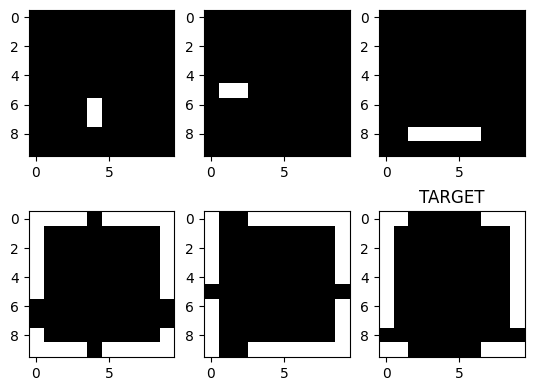

In [3]:
#this cell is for reformatting the df; one could e.g. slice off specific data here (e.g., for a test set with new analogies)
long_data = data.reshape(data.shape[0]*data.shape[1], data.shape[2], data.shape[3], data.shape[4], data.shape[5])
long_data = long_data.reshape(long_data.shape[0], long_data.shape[1] * long_data.shape[2], long_data.shape[3], long_data.shape[4])
plot_double_trio(long_data[8]) #first 9 on first dim are same trio and all 9 transformations; then it starts over with second trio
nonduplicates = np.unique(long_data, axis=0) #get rid of duplicated tasks
print(f"{np.round(100*(1 - nonduplicates.shape[0] / long_data.shape[0]),1)}% double trios were duplicated") 

In [4]:
with open("nonduplicates.pkl", "wb") as f:
    pickle.dump(nonduplicates, file=f)

In [5]:
import torch
from sklearn.model_selection import train_test_split

# Split into input (x) and output (y)
x_data = nonduplicates[:, :-1, :, :] / 255 # All but the last channel
y_data = nonduplicates[:, -1, :, :] / 255  # Only the last channel

# Convert to PyTorch tensors
x_data = torch.from_numpy(x_data).float()
y_data = torch.from_numpy(y_data).float()

# Split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.005, random_state=42)

# Print the shapes of the resulting tensors
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: torch.Size([892890, 5, 10, 10])
y_train shape: torch.Size([892890, 10, 10])
x_test shape: torch.Size([4487, 5, 10, 10])
y_test shape: torch.Size([4487, 10, 10])


In [15]:
#basic feed forward test
class FullyConnectedNN(nn.Module):
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        self.flatten = nn.Flatten()  
        self.fc1 = nn.Linear(5 * 10 * 10, 150) 
        self.relu1 = nn.ReLU()  
        self.fc2 = nn.Linear(150, 150) 
        self.relu2 = nn.ReLU() 
        self.fc3 = nn.Linear(150, 150) 
        self.relu3 = nn.ReLU() 
        self.fc4 = nn.Linear(150, 10 * 10) 
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x.view(-1, 10, 10)  # Reshape the output to be 10x10

# Create an instance of the model
model = FullyConnectedNN()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0)

num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    train_outputs = model(x_train)
    loss = criterion(train_outputs, y_train)

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            test_outputs = model(x_test)
            test_loss = criterion(test_outputs, y_test)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Test: {test_loss.item():.4f}')

Epoch [1/500], Loss: 0.2509
Test Loss: 0.2401
Epoch [2/500], Loss: 0.2390
Test Loss: 0.1929
Epoch [3/500], Loss: 0.1909
Test Loss: 0.1507
Epoch [4/500], Loss: 0.1482
Test Loss: 0.1393
Epoch [5/500], Loss: 0.1376
Test Loss: 0.1340
Epoch [6/500], Loss: 0.1325
Test Loss: 0.1263
Epoch [7/500], Loss: 0.1254
Test Loss: 0.1212
Epoch [8/500], Loss: 0.1206
Test Loss: 0.1202
Epoch [9/500], Loss: 0.1189
Test Loss: 0.1156
Epoch [10/500], Loss: 0.1152
Test Loss: 0.1180
Epoch [11/500], Loss: 0.1179
Test Loss: 0.1145
Epoch [12/500], Loss: 0.1138
Test Loss: 0.1141
Epoch [13/500], Loss: 0.1135
Test Loss: 0.1121
Epoch [14/500], Loss: 0.1119
Test Loss: 0.1123
Epoch [15/500], Loss: 0.1123
Test Loss: 0.1120
Epoch [16/500], Loss: 0.1119
Test Loss: 0.1115
Epoch [17/500], Loss: 0.1112
Test Loss: 0.1093
Epoch [18/500], Loss: 0.1089
Test Loss: 0.1082
Epoch [19/500], Loss: 0.1074
Test Loss: 0.1070
Epoch [20/500], Loss: 0.1059
Test Loss: 0.1050
Epoch [21/500], Loss: 0.1038
Test Loss: 0.1030
Epoch [22/500], Loss: 

In [16]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Nr params: {pytorch_total_params}")

Nr params: 135550


<Figure size 1200x400 with 0 Axes>

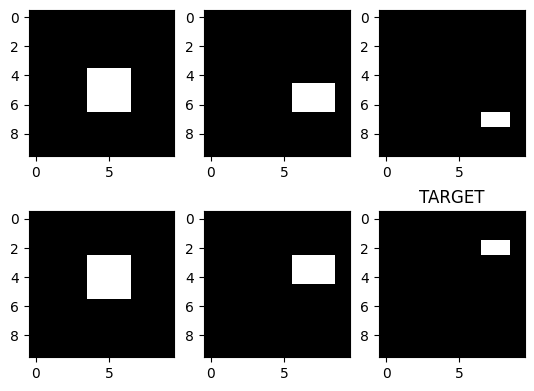

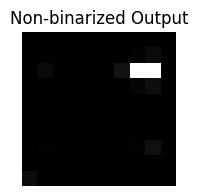

In [24]:
plot_exmp = 0
with torch.no_grad():
    y  = y_test[plot_exmp].expand(1, y_test[plot_exmp].shape[0], y_test[plot_exmp].shape[1])
    example = torch.row_stack((x_test[plot_exmp], y))
    plot_double_trio(example)
    plt.figure(figsize=(6, 2))
    plt.title("Non-binarized Output")
    plt.imshow(model(x_test[plot_exmp].unsqueeze(0))[0], cmap='gray')
    plt.axis('off')
    plt.show()